In [2]:
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('../')

from data.classes import *
from data.utils import *

In [3]:
arr = np.load('/fs/nexus-scratch/ayang115/dmv_dataset/numpy/GOES_Landsat_image_0-0000000000-0000000000.npy')

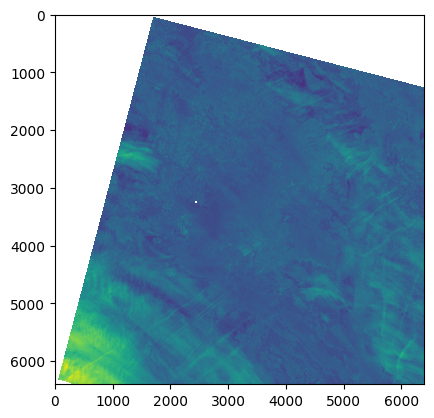

In [4]:
# def create_tiles(arr, x_size, y_size, stride=256):
#     x_tiles = np.arange(0, arr.shape[-1]//stride)
#     y_tiles = np.arange(0, arr.shape[-2]//stride)
#     tiles = []
#     for x in x_tiles:
#         for y in y_tiles:
#             tile = arr[::, x*stride:x*stride+x_size, y*stride:y*stride+y_size]
#             if np.isnan(np.min(tile)): tiles.append(np.zeros(tile.shape))
#             else: tiles.append(tile)
    
#     return np.stack(tiles, axis=0)

# rand = 4000
# subset = arr[:, rand:rand+512, rand:rand+512]
# tiles = create_tiles(subset, 256, 256, 256)

plt.imshow(arr[1])
plt.show()

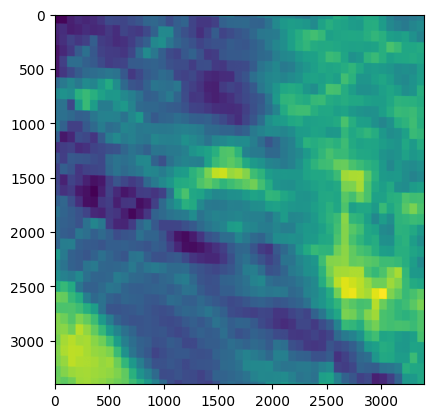

In [7]:
plt.imshow(arr[7][3000::, 3000::])

In [20]:
def to_cloud_mask(num):
    if np.isnan(num):
        return np.nan
    else:
        bit_string = f'{int(num):b}'
        if bit_string[6]==1:
            return 1
        else:  
            return 0
    
def cloud_percentage(mask):
    return np.sum(mask)/mask.size

vec = np.vectorize(to_cloud_mask)
binary = vec(subset[6])
print(cloud_percentage(binary))

0.0


In [23]:
len('1101011100001100')

16

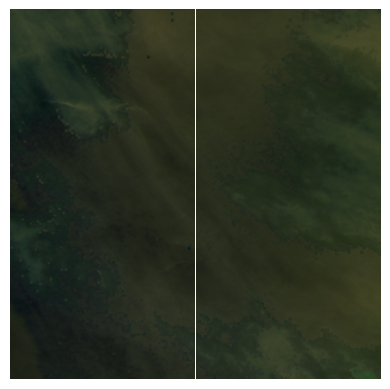

In [193]:
fig, axs = plt.subplots(2, 2)

axs[0][0].imshow(tiles[0][[1,2,3]].squeeze().transpose(1,2,0))
axs[0][1].imshow(tiles[1][[1,2,3]].squeeze().transpose(1,2,0))
axs[1][0].imshow(tiles[2][[1,2,3]].squeeze().transpose(1,2,0))
axs[1][1].imshow(tiles[3][[1,2,3]].squeeze().transpose(1,2,0))

for ax in axs.flatten():
    ax.axis('off')
fig.subplots_adjust(hspace=0, wspace=-0.4)
plt.axis('off')
plt.show()


In [30]:
def UTM_to_lat_lon(easting_array, northing_array, EPSG):
    crs = CRS.from_user_input(EPSG)
    zone = int(crs.coordinate_operation.name[-3:-1])
    north = crs.coordinate_operation.name[-1:] == 'N'

    latitude = []
    longitude = []

    for val in easting_array:
        lon = utm.to_latlon(easting=val, northing=0, zone_number=zone, northern=north)[1].values
        longitude.append(lon)
    for val in northing_array:
        lat = utm.to_latlon(easting=100000, northing=val, zone_number=zone, northern=north)[0].values
        latitude.append(lat)

    return latitude, longitude

In [31]:
latitude, longitude = UTM_to_lat_lon(geotiff_ds.x, geotiff_ds.y, 32618)

In [32]:
geotiff_ds['x'] = longitude
geotiff_ds['y'] = latitude

In [33]:
geotiff_ds = geotiff_ds.rename({'x':'longitude', 'y':'latitude'})

In [36]:
def to_binary_string(num):
    if np.isnan(num):
        return np.nan
    else:
        return f'{int(num):b}'

In [37]:
mask = xr.DataArray([[to_binary_string(x) for x in line] for line in geotiff_ds.Landsat_Cloud_Mask.values])
mask = mask.rename({'dim_0':'latitude', 'dim_1':'longitude'})
geotiff_ds['Landsat_Cloud_Mask'] = mask

In [64]:
ds = geotiff_ds.Landsat_Blue_Vis_Sfc_Reflectance.values
ds = np.nan_to_num(ds, nan=-1)

In [66]:
ds.max(), ds.min()

(np.float64(0.9075900000000001), np.float64(-1.0))

In [20]:
geotiff_ds = geotiff_ds.assign_attrs(
    Cloud_Mask_Bits="Bit 0: Fill\nBit 1: Dilated Cloud\nBit 2: Cirrus (high confidence)\nBit 3: Cloud\nBit 4: Cloud Shadow\n\
Bit 5: Snow\nBit 6: Clear\n    0: Cloud or Dilated Cloud bits are set\n    1: Cloud and Dilated Cloud bits are not set\nBit 7: Water\n\
Bits 8-9: Cloud Confidence\n    0: None\n    1: Low\n    2: Medium\n    3: High\n\
Bits 10-11: Cloud Shadow Confidence\n    0: None\n    1: Low\n    2: Medium\n    3: High\n\
Bits 12-13: Snow/Ice Confidence\n    0: None\n    1: Low\n    2: Medium\n    3: High\n\
Bits 14-15: Cirrus Confidence\n    0: None\n    1: Low\n    2: Medium\n    3: High")

In [24]:
geotiff_ds = geotiff_ds.assign_attrs(Datetime=str(times.value[0]))

In [25]:
geotiff_ds

<xarray.Dataset>
Dimensions:                             (latitude: 6400, longitude: 6400)
Coordinates:
  * longitude                           (longitude) float64 -77.51 ... -75.79
  * latitude                            (latitude) float64 39.9 39.9 ... 38.17
    spatial_ref                         int64 0
Data variables: (12/14)
    Landsat_Blue_Vis_Sfc_Reflectance    (latitude, longitude) float64 ...
    Landsat_Red_Vis_Sfc_Reflectance     (latitude, longitude) float64 ...
    Landsat_NIR_Sfc_Reflectance         (latitude, longitude) float64 ...
    Landsat_SWIR1_Sfc_Reflectance       (latitude, longitude) float64 ...
    Landsat_SWIR2_Sfc_Reflectance       (latitude, longitude) float64 ...
    Landsat_LST                         (latitude, longitude) float64 ...
    ...                                  ...
    GOES_Red_Vis_Reflectance            (latitude, longitude) float64 ...
    GOES_NIR_Veggie_Reflectance         (latitude, longitude) float64 ...
    GOES_NIR_SnowIce_Reflectance        (latitude, longitude) float64 ...
    GOES_NIR_CloudParticle_Reflectance  (latitude, longitude) float64 ...
    GOES_LWIR_Brightness_Temp           (latitude, longitude) float64 ...
    GOES_Dirty_LWIR_Brightness_temp     (latitude, longitude) float64 ...
Attributes:
    AREA_OR_POINT:    Area
    scale_factor:     1.0
    add_offset:       0.0
    long_name:        ('SR_B2', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ST_B10',...
    Cloud_Mask_Bits:  Bit 0: Fill\nBit 1: Dilated Cloud\nBit 2: Cirrus (high ...
    Datetime:         2023-01-11 10:46:33.089500

In [ ]:
# Export the data
#geotiff_ds.rio.to_raster("first.tif")
geotiff_ds.to_netcdf('first.nc')

In [27]:
xr.load_dataset('first.nc')

<xarray.Dataset>
Dimensions:                             (latitude: 6400, longitude: 6400)
Coordinates:
  * longitude                           (longitude) float64 -77.51 ... -75.79
  * latitude                            (latitude) float64 39.9 39.9 ... 38.17
Data variables: (12/15)
    Landsat_Blue_Vis_Sfc_Reflectance    (latitude, longitude) float64 nan ......
    Landsat_Red_Vis_Sfc_Reflectance     (latitude, longitude) float64 nan ......
    Landsat_NIR_Sfc_Reflectance         (latitude, longitude) float64 nan ......
    Landsat_SWIR1_Sfc_Reflectance       (latitude, longitude) float64 nan ......
    Landsat_SWIR2_Sfc_Reflectance       (latitude, longitude) float64 nan ......
    Landsat_LST                         (latitude, longitude) float64 nan ......
    ...                                  ...
    GOES_NIR_Veggie_Reflectance         (latitude, longitude) float64 0.1299 ...
    GOES_NIR_SnowIce_Reflectance        (latitude, longitude) float64 0.06935...
    GOES_NIR_CloudParticle_Reflectance  (latitude, longitude) float64 0.06691...
    GOES_LWIR_Brightness_Temp           (latitude, longitude) float64 274.2 ....
    GOES_Dirty_LWIR_Brightness_temp     (latitude, longitude) float64 273.1 ....
    spatial_ref                         int64 0
Attributes:
    AREA_OR_POINT:    Area
    scale_factor:     1.0
    add_offset:       0.0
    long_name:        ['SR_B2', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ST_B10',...
    Cloud_Mask_Bits:  Bit 0: Fill\nBit 1: Dilated Cloud\nBit 2: Cirrus (high ...
    Datetime:         2023-01-11 10:46:33.089500

In [ ]:
######################################################
# End of tif processing part
# Below is gridding of Baltimore

In [36]:
grid_lats = [39.2576, 39.3147, 39.3718]
grid_lons = [-76.5299, -76.6204, -76.7108]

In [37]:
grid1 = geotiff_ds.sel(x=slice(grid_lons[2], grid_lons[1])).sel(y=slice(grid_lats[2], grid_lats[1]))
grid2 = geotiff_ds.sel(x=slice(grid_lons[1], grid_lons[0])).sel(y=slice(grid_lats[2], grid_lats[1]))
grid3 = geotiff_ds.sel(x=slice(grid_lons[2], grid_lons[1])).sel(y=slice(grid_lats[1], grid_lats[0]))
grid4 = geotiff_ds.sel(x=slice(grid_lons[1], grid_lons[0])).sel(y=slice(grid_lats[1], grid_lats[0]))

In [39]:
grid4

<xarray.Dataset>
Dimensions:      (y: 212, x: 336)
Coordinates:
  * x            (x) float64 -76.62 -76.62 -76.62 ... -76.53 -76.53 -76.53
  * y            (y) float64 39.31 39.31 39.31 39.31 ... 39.26 39.26 39.26 39.26
    spatial_ref  int64 0
Data variables: (12/14)
    1            (y, x) float64 ...
    2            (y, x) float64 ...
    3            (y, x) float64 ...
    4            (y, x) float64 ...
    5            (y, x) float64 ...
    6            (y, x) float64 ...
    ...           ...
    9            (y, x) float64 ...
    10           (y, x) float64 ...
    11           (y, x) float64 ...
    12           (y, x) float64 ...
    13           (y, x) float64 ...
    14           (y, x) float64 ...
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('SR_B2', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ST_B10', '...